In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import numpy as np
import tqdm
import glob as glob
import cProfile
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from PIL import Image
import imageio
from keras import backend as K
import cv2

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
## Memory settings
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True # dynamically grow the memory used on the GPU
config.log_device_placement = True # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
## ---- end Memory setting ----

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
img_height = 1024
img_width = 1232
batch_size= 1

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
train_datagen_image = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_datagen_mask = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [9]:
train_flow_image = train_datagen_image.flow_from_directory("/content/drive/MyDrive/uhaworkspace/parking_ensisa/HW_2/img_train",
                                               target_size=(img_height,img_width),
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=5,
                                               class_mode = None)


Found 160 images belonging to 1 classes.


In [10]:
train_flow_mask = train_datagen_image.flow_from_directory("/content/drive/MyDrive/uhaworkspace/parking_ensisa/HW_2/mask_train",
                                               target_size=(img_height,img_width),
                                               color_mode='grayscale',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=5,
                                               class_mode = None)

Found 160 images belonging to 1 classes.


In [11]:
valid_datagen_image = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_datagen_mask = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [13]:
valid_flow_image = valid_datagen_image.flow_from_directory("/content/drive/MyDrive/uhaworkspace/parking_ensisa/HW_2/img_valid",
                                               target_size=(img_height,img_width),
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=8,
                                               class_mode = None)

Found 40 images belonging to 1 classes.


In [14]:
valid_flow_mask = valid_datagen_image.flow_from_directory("/content/drive/MyDrive/uhaworkspace/parking_ensisa/HW_2/mask_valid",
                                               target_size=(img_height,img_width),
                                               color_mode='grayscale',
                                               shuffle=False,
                                               batch_size=batch_size,
                                               seed=8,
                                               class_mode = None)

Found 40 images belonging to 1 classes.


In [16]:
N1 = len(train_flow_mask)
train_masks = np.zeros((N1,img_height, img_width, 1), dtype=np.float32)
for n in range(N1):
    mask = train_flow_mask[n]
    mask = np.reshape(mask,(img_height,img_width))
    mask_road = np.zeros((img_height,img_width, 1), dtype=np.float32)
    mask_road[np.where(mask==0.6666667)[0], np.where(mask==0.6666667)[1]]=1
    mask_road = np.reshape(mask_road,(img_height,img_width,1))
    train_masks[n]=mask_road
train_flow_mask1 = valid_datagen_image.flow(train_masks,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=5)

In [17]:
N2 = len(valid_flow_mask)
valid_masks = np.zeros((N2,img_height, img_width, 1), dtype=np.float32)
for n in range(N2):
    mask1 = valid_flow_mask[n]
    mask1 = np.reshape(mask1,(img_height, img_width))
    mask_road1 = np.zeros((img_height, img_width, 1), dtype=np.float32)
    mask_road1[np.where(mask1==0.6666667)[0], np.where(mask1==0.6666667)[1]]=1
    valid_masks[n] = mask_road1
valid_flow_mask1 = valid_datagen_image.flow(valid_masks,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               seed=8)

train_generator = zip(train_flow_image,train_flow_mask1)
valid_generator = zip(valid_flow_image,valid_flow_mask1)


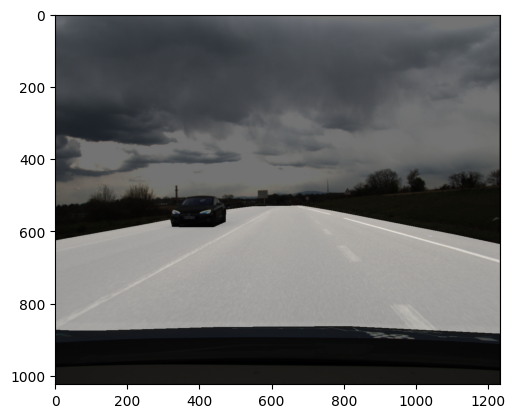

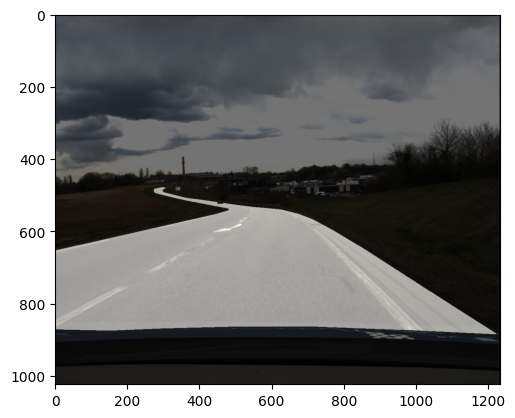

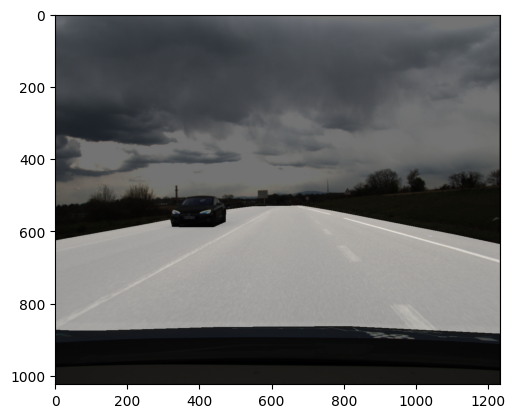

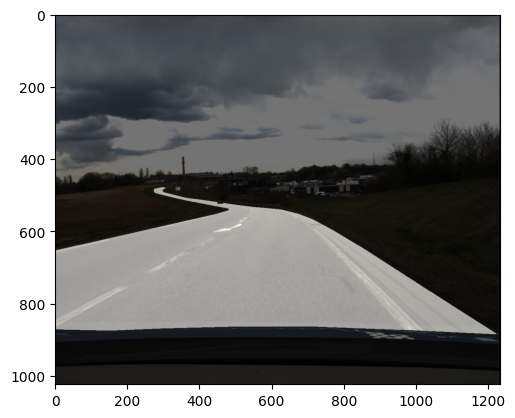

In [18]:
#visualisation test
w = 38
plt.figure(1)
plt.imshow(train_flow_image[w][0])
plt.imshow(train_flow_mask[w][0],cmap='gray',alpha=0.55)
plt.figure(3)
plt.imshow(valid_flow_image[w][0])
plt.imshow(valid_flow_mask[w][0],cmap='gray',alpha=0.55)
plt.figure(5)
plt.imshow(train_flow_image[w][0])
plt.imshow(train_flow_mask1[w][0],cmap='gray',alpha=0.55)
plt.figure(7)
plt.imshow(valid_flow_image[w][0])
plt.imshow(valid_flow_mask1[w][0],cmap='gray',alpha=0.55)

In [19]:
# #encoder
dr = 0.25
from tensorflow.keras import regularizers
inputs = keras.layers.Input(shape=(img_height,img_width,3))
encoder1_1 = keras.layers.Conv2D(32,(3,3),padding = 'same',activation='relu')(inputs)
encoder1_2 = keras.layers.Conv2D(32,(3,3),padding = 'same',activation='relu')(encoder1_1)
encoder1_pool = keras.layers.MaxPooling2D(pool_size=(2,2))(encoder1_2)
encoder1_pool = keras.layers.Dropout(dr)(encoder1_pool)

encoder2_1 = keras.layers.Conv2D(64,(3,3),padding = 'same',activation='relu')(encoder1_pool)
encoder2_2 = keras.layers.Conv2D(64,(3,3),padding = 'same',activation='relu')(encoder2_1)
encoder2_pool = keras.layers.MaxPooling2D(pool_size=(2,2))(encoder2_2)
encoder2_pool = keras.layers.Dropout(dr)(encoder2_pool)

encoder3_1 = keras.layers.Conv2D(128,(3,3),padding = 'same',activation='relu')(encoder2_pool)
encoder3_2 = keras.layers.Conv2D(128,(3,3),padding = 'same',activation='relu')(encoder3_1)
encoder3_pool = keras.layers.MaxPooling2D(pool_size=(2,2))(encoder3_2)
encoder3_pool = keras.layers.Dropout(dr)(encoder3_pool)


center_1 = keras.layers.Conv2D(256,(3,3),padding = 'same',activation='relu')(encoder3_pool)
center_2 = keras.layers.Conv2D(256,(3,3),padding = 'same',activation='relu')(center_1)


#Decoder
decoder3_1 = keras.layers.UpSampling2D(size=(2,2))(center_2)
decoder3_2 = keras.layers.concatenate([encoder3_2,decoder3_1],axis=3)
decoder3_3 = keras.layers.Conv2D(128,(3,3),padding = 'same',activation='relu')(decoder3_2)
decoder3_4 = keras.layers.Conv2D(128,(3,3),padding = 'same',activation='relu')(decoder3_3)
decoder3_4 = keras.layers.Dropout(dr)(decoder3_4)

decoder2_1 = keras.layers.UpSampling2D(size=(2,2))(decoder3_4)
decoder2_2 = keras.layers.concatenate([encoder2_2,decoder2_1],axis=3)
decoder2_3 = keras.layers.Conv2D(64,(3,3),padding = 'same',activation='relu')(decoder2_2)
decoder2_4 = keras.layers.Conv2D(64,(3,3),padding = 'same',activation='relu')(decoder2_3)
decoder2_4 = keras.layers.Dropout(dr+0.1)(decoder2_4)

decoder1_1 = keras.layers.UpSampling2D(size=(2,2))(decoder2_4)
#128 128
decoder1_2 = keras.layers.concatenate([encoder1_2,decoder1_1],axis=3)
decoder1_3 = keras.layers.Conv2D(32,(3,3),padding = 'same',activation='relu')(decoder1_2)
decoder1_4 = keras.layers.Conv2D(32,(3,3),padding = 'same',activation='relu')(decoder1_3)
decoder1_4 = keras.layers.Dropout(dr+0.3)(decoder1_4)

outputs = keras.layers.Conv2D(1,(1,1),padding = 'same',activation='sigmoid')(decoder1_4)



In [20]:
my_model = keras.models.Model(inputs =inputs,outputs=outputs)

In [21]:
my_model.summary()
#keras.utils.plot_model(my_model,to_file='model_seg1.png',dpi=300,show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1232, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 1232, 32)       896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1024, 1232, 32)       9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 512, 616, 32)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [22]:
model_checkpoint = [ReduceLROnPlateau(patience=6, verbose=1),
                    keras.callbacks.ModelCheckpoint(
                    filepath='/content/drive/MyDrive/uhaworkspace/parking_ensisa/HW_2/model_weights/DL_ENSISA_HW_epch-{epoch:02d}_loss-{loss:.2f}_val_acc-{val_accuracy:.2f}.h5',
                                                   monitor = 'val_loss',
                                                   verbose=1,
                                                   save_best_only=True,
                                                   save_weights_only=False,
                                                   mode='auto',
                                                   period=1)]

my_model.compile(loss = keras.losses.binary_crossentropy,optimizer = keras.optimizers.Adam(lr=0.00001),metrics=['accuracy'])

In [25]:
n_epoch = 25
history = my_model.fit_generator(train_generator,
                                 epochs =n_epoch,
                                 validation_data = valid_generator,
                                 verbose=1,
                                 steps_per_epoch=25//batch_size,
                                 validation_steps = 10//batch_size,
                                 callbacks=[model_checkpoint])

<ipython-input-25-907c3eb3cf7c>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = my_model.fit_generator(train_generator,


Epoch 1/25
25/25 [==============================] - ETA: 0s - loss: 0.0932 - accuracy: 0.6742
Epoch 1: val_loss improved from inf to 0.01107, saving model to /content/drive/MyDrive/uhaworkspace/parking_ensisa/HW_2/model_weights/DL_ENSISA_HW_epch-01_loss-0.09_val_acc-0.70.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 40s 735ms/step - loss: 0.0932 - accuracy: 0.6742 - val_loss: 0.0111 - val_accuracy: 0.7022 - lr: 0.0010
Epoch 2/25
25/25 [==============================] - ETA: 0s - loss: 0.0131 - accuracy: 0.7127
Epoch 2: val_loss improved from 0.01107 to 0.00749, saving model to /content/drive/MyDrive/uhaworkspace/parking_ensisa/HW_2/model_weights/DL_ENSISA_HW_epch-02_loss-0.01_val_acc-0.74.h5
25/25 [==============================] - 17s 677ms/step - loss: 0.0131 - accuracy: 0.7127 - val_loss: 0.0075 - val_accuracy: 0.7414 - lr: 0.0010
Epoch 3/25
25/25 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.7419
Epoch 3: val_loss improved from 0.00749 to 0.00612, saving model to /content/drive/MyDrive/uhaworkspace/parking_ensisa/HW_2/model_weights/DL_ENSISA_HW_epch-03_loss-0.01_val_acc-0.78.h5
25/25 [==============================] - 21s 869ms/step - loss: 0.0102 - accuracy: 0.7419 - val_loss: 0.0061 - val_accuracy: 0.7769 - lr: 0.0010
Epoch 4

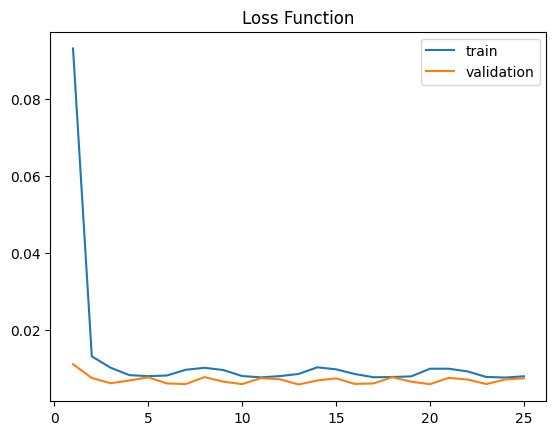

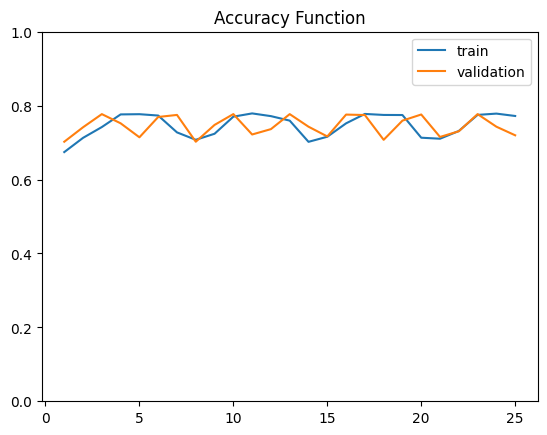

In [26]:
#loss curves

plt.figure()
plt.plot(range(1,n_epoch+1),history.history['loss'])
plt.plot(range(1,n_epoch+1),history.history['val_loss'])
plt.legend(['train','validation'])
plt.title('Loss Function')
plt.show()
plt.figure()
plt.plot(range(1,n_epoch+1),history.history['accuracy'])
plt.plot(range(1,n_epoch+1),history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.ylim(0,1)
plt.title('Accuracy Function')
plt.show()

In [27]:
# my_model = keras.models.save_model('/content/drive/MyDrive/uhaworkspace/parking_ensisa/HW_2/model_weights/DL_KITTI_highway.h5')

In [28]:
final_metrics = np.zeros((N2,4))
final_metrics.shape
for n in range(N2):
    img = valid_flow_image[n][0]
    h,w,c = img.shape
    img_1 = cv2.resize(img,(img_width,img_height))

    img_1=np.expand_dims(img_1,axis=0)
    result = my_model.predict(img_1)
    mask = result[0]
    mask  = cv2.resize(mask,(w,h))
    mask = mask*255.0
    res,mask = cv2.threshold(mask,0.5,255,cv2.THRESH_BINARY)
    intermediary = mask
    res2,ypred = cv2.threshold(intermediary,0.5,1,cv2.THRESH_BINARY)
    ytrue_raw = valid_flow_mask1[n][0]

    ytrue = np.zeros((img_height, img_width))
    ytrue = np.reshape(ytrue,(img_height, img_width))
    res3,ytrue= cv2.threshold(ytrue_raw,0.00001,1,cv2.THRESH_BINARY)

    final_metrics[n][0] = f1_m(ypred,ytrue)
    final_metrics[n][1] = recall_m(ypred,ytrue)
    final_metrics[n][2] = precision_m(ypred,ytrue)
    final_metrics[n][3] = n
print('End Eval Val\n f1, recall, precision, image_nr')
final_metrics

1/1 [==============================] - 0s 27ms/step
End Eval Val
 f1, recall, precision, image_nr


array([[ 0.89481997,  0.9993785 ,  0.81006801,  0.        ],
       [ 0.89615476,  0.99892819,  0.81255609,  1.        ],
       [ 0.8957333 ,  0.99975133,  0.81132048,  2.        ],
       [ 0.91583353,  0.99987531,  0.84482425,  3.        ],
       [ 0.89269459,  0.99977934,  0.80632997,  4.        ],
       [ 0.87580073,  0.99998957,  0.77905047,  5.        ],
       [ 0.89780045,  0.99915886,  0.81511241,  6.        ],
       [ 0.91470361,  0.99929625,  0.84331518,  7.        ],
       [ 0.9078967 ,  0.99932855,  0.83179325,  8.        ],
       [ 0.88676214,  0.99434048,  0.80018932,  9.        ],
       [ 0.89076287,  0.99802834,  0.80431712, 10.        ],
       [ 0.85745358,  0.99866873,  0.75122756, 11.        ],
       [ 0.85749352,  0.99911004,  0.75103933, 12.        ],
       [ 0.84625167,  0.99968493,  0.73364997, 13.        ],
       [ 0.88307256,  0.99946547,  0.79096109, 14.        ],
       [ 0.85284454,  0.99922103,  0.74387413, 15.        ],
       [ 0.79185468,  0.

In [29]:
F1_average = np.mean(final_metrics[:,0])
F1_max = np.max(final_metrics[:,0])
F1_min = np.min(final_metrics[:,0])
print('Mean F1: ', F1_average)
print('Max F1: ', F1_max)
print('Min F1: ', F1_min)

Mean F1:  0.9035908326506614
Max F1:  0.9767827987670898
Min F1:  0.7918546795845032


Best Case Validation. Image nr. 37
1/1 [==============================] - 0s 27ms/step
F1 Measure : 0.9767827987670898


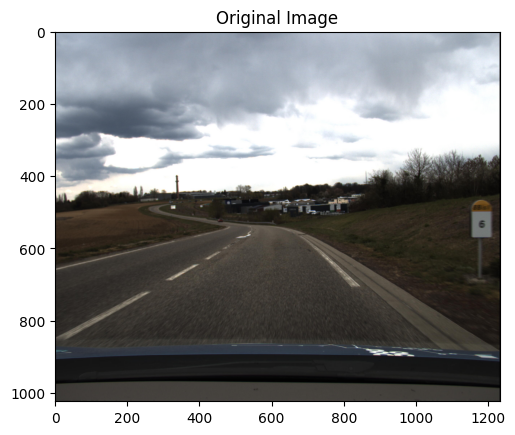

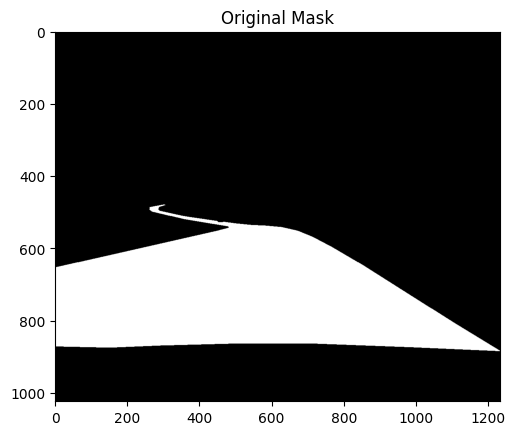

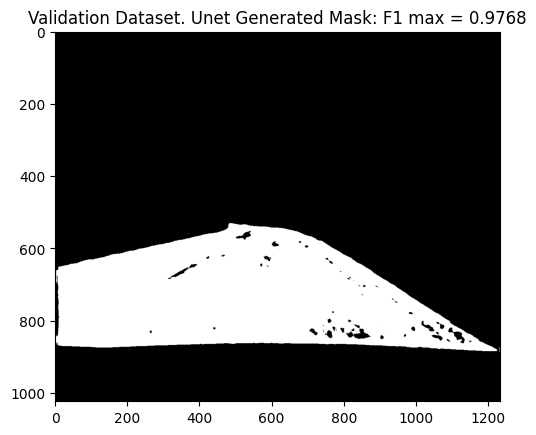

In [30]:
#the best valid
max_index_row = np.argmax(final_metrics[:,0], axis=0)
print('Best Case Validation. Image nr.', max_index_row)
n = max_index_row
img = valid_flow_image[n][0]
h,w,c = img.shape
img_1 = cv2.resize(img,(img_width,img_height))
msk = valid_flow_mask1[n][0]
plt.figure(1)
plt.imshow(img)
plt.title('Original Image')
plt.figure(2)
plt.imshow(msk,cmap='gray')
plt.title('Original Mask')
img_1.shape
img_1=np.expand_dims(img_1,axis=0)
result = my_model.predict(img_1)
mask = result[0]
mask  = cv2.resize(mask,(w,h))
mask = mask*255.0
res,mask = cv2.threshold(mask,0.5,255,cv2.THRESH_BINARY)
plt.figure(4)
plt.imshow(mask,cmap='gray')
plt.title('Validation Dataset. Unet Generated Mask: F1 max = {:.4f}'.format(F1_max))
print('F1 Measure :',F1_max)

Worst Case Validation. Image nr. 16
1/1 [==============================] - 0s 31ms/step
F1 Measure: 0.7918546795845032


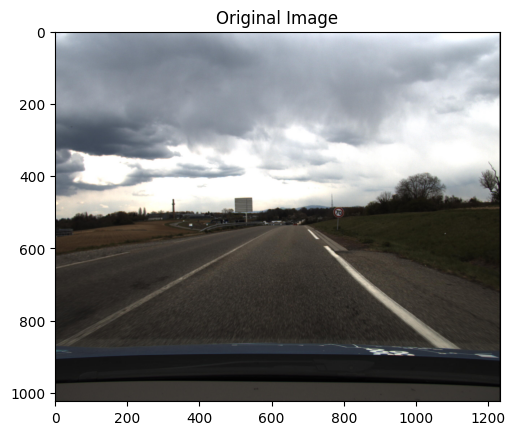

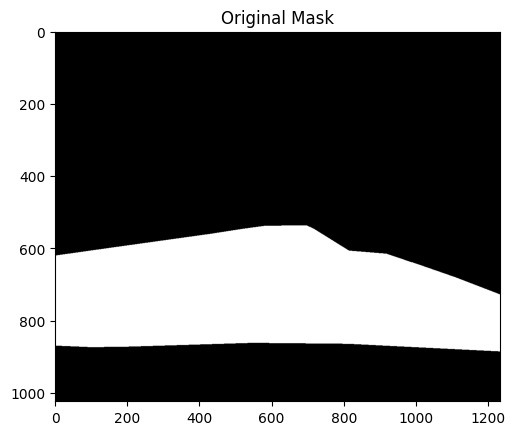

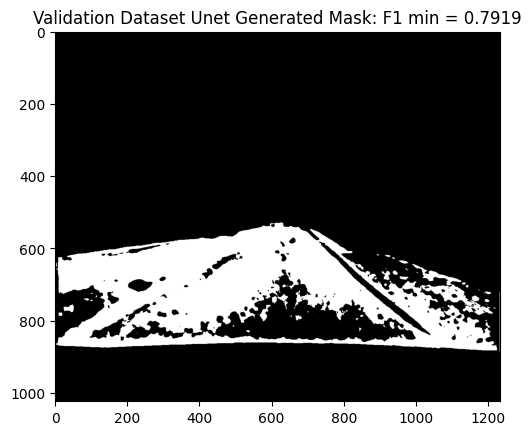

In [31]:
#the worst valid
min_index_row = np.argmin(final_metrics[:,0], axis=0)
print('Worst Case Validation. Image nr.',min_index_row)
n = min_index_row
img = valid_flow_image[n][0]
h,w,c = img.shape
img_1 = cv2.resize(img,(img_width,img_height))
msk = valid_flow_mask1[n][0]
plt.figure(1)
plt.imshow(img)
plt.title('Original Image')
plt.figure(2)
plt.imshow(msk,cmap='gray')
plt.title('Original Mask')
img_1.shape
img_1=np.expand_dims(img_1,axis=0)
result = my_model.predict(img_1)
mask = result[0]
mask  = cv2.resize(mask,(w,h))
mask = mask*255.0
res,mask = cv2.threshold(mask,0.5,255,cv2.THRESH_BINARY)
plt.figure(4)

plt.imshow(mask,cmap='gray')
plt.title('Validation Dataset Unet Generated Mask: F1 min = {:.4f}'.format(F1_min))
print('F1 Measure:',F1_min)